# Monitoring PyTorch experiments with TensorBoard

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.utils.data import DataLoader
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

plt.ion()   # interactive mode

## Setup

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [3]:
device

device(type='cuda', index=0)

## Load data

In [4]:
def get_dataloaders(data_dir, batch_size):
    """Creates training and validation splits."""
    
    data_transforms = {
        'train': transforms.Compose([
            transforms.RandomResizedCrop(256),
            transforms.RandomHorizontalFlip(),
            transforms.CenterCrop(size=224),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ]),
        'val': transforms.Compose([
            transforms.Resize(256),
            transforms.CenterCrop(224),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ])
    }
    
    data = {
        'train': 
            datasets.ImageFolder(root=os.path.join(data_dir, 'train'),
                                 transform=data_transforms['train']),
        'val':
            datasets.ImageFolder(root=os.path.join(data_dir, 'val'),
                                 transform=data_transforms['val'])
    }
    
    datasizes = {
        'train': len(data['train']),
        'val': len(data['val'])
    }
    
    dataloaders = {
        'train': 
            DataLoader(data['train'], batch_size=batch_size, shuffle=True),
        'val':
            DataLoader(data['val'], batch_size=batch_size, shuffle=True)
    }
    
    class_names = data['train'].classes
    
    return dataloaders, datasizes, class_names
    

Get data 
```
cd /tmp
mkdir data
cd data
wget https://download.pytorch.org/tutorial/hymenoptera_data.zip
unzip hymenoptera_data.zip
```

In [5]:
data_dir = '/tmp/data/hymenoptera_data'
batch_size = 4

dataloaders, _, class_names = get_dataloaders(data_dir, batch_size)

In [6]:
trainiter = iter(dataloaders['train'])
features, labels = next(trainiter)
features.shape, labels.shape

(torch.Size([4, 3, 224, 224]), torch.Size([4]))

## Visualize a few images

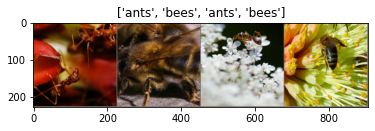

In [7]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(trainiter)

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

## Define a model

In [8]:
def get_model(num_layers, dropout_ratio, num_classes):
    """
    Creates a convolution net using ResNet50 trunk and
    a custom head.
    """
    
    # Get the number of input features to the default head
    model = models.resnet50(pretrained=True)
    num_features = model.fc.in_features
    
    # Freeze trunk weights
    for param in model.parameters():
        param.requires_grad = False
    
    # Define a new head
    head = nn.Sequential(nn.Linear(num_features, num_layers),
                         nn.ReLU(),
                         nn.Dropout(dropout_ratio),
                         nn.Linear(num_layers, num_classes))
    
    # Replace the head
    model.fc = head
    
    return model
    

In [9]:
num_layers = 64
dropout_ratio = 0.5
num_classes = 2

model = get_model(num_layers, dropout_ratio, num_classes)


## Inspect the model

In [10]:
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [11]:
model.fc

Sequential(
  (0): Linear(in_features=2048, out_features=64, bias=True)
  (1): ReLU()
  (2): Dropout(p=0.5, inplace=False)
  (3): Linear(in_features=64, out_features=2, bias=True)
)

In [12]:
total_params = sum(p.numel() for p in model.parameters())
print(f'{total_params:,} total parameters.')
total_trainable_params = sum(
    p.numel() for p in model.parameters() if p.requires_grad)
print(f'{total_trainable_params:,} training parameters.')

23,639,298 total parameters.
131,266 training parameters.


## Define a training loop

In [13]:
from torch.utils.tensorboard import SummaryWriter

def train_model(device, dataloaders, dataset_sizes, model, criterion, 
                optimizer, scheduler, num_epochs=25, log_dir='/tmp'):
    
    since = time.time()
    writer = SummaryWriter(log_dir)
    
    
    

    model = model.to(device)
    
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))
            
            # Write loss and accuracy to TensorBoard
            writer.add_scalar(f'Loss/{phase}', epoch_loss, epoch)
            writer.add_scalar(f'Acc/{phase}', epoch_acc, epoch)

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    writer.close()
    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

## Start training

In [14]:
criterion = nn.CrossEntropyLoss()
optimizer_ft = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)


data_dir = '/tmp/data/hymenoptera_data'
batch_size = 32
log_dir = 'gs://jk-tensorboards/experiments/102'
num_epochs = 50


In [15]:
dataloaders, datasizes, class_names = get_dataloaders(data_dir, batch_size)

model = train_model(device, dataloaders, datasizes, model, criterion, 
                    optimizer_ft, exp_lr_scheduler, num_epochs, log_dir)

Epoch 0/49
----------
train Loss: 0.7167 Acc: 0.4549
val Loss: 0.6644 Acc: 0.6797

Epoch 1/49
----------
train Loss: 0.6715 Acc: 0.5820
val Loss: 0.6064 Acc: 0.7582

Epoch 2/49
----------
train Loss: 0.6246 Acc: 0.6967
val Loss: 0.5700 Acc: 0.9085

Epoch 3/49
----------
train Loss: 0.5765 Acc: 0.7541
val Loss: 0.5224 Acc: 0.9085

Epoch 4/49
----------
train Loss: 0.5331 Acc: 0.8279
val Loss: 0.4662 Acc: 0.9150

Epoch 5/49
----------
train Loss: 0.4758 Acc: 0.8730
val Loss: 0.4214 Acc: 0.9281

Epoch 6/49
----------
train Loss: 0.4621 Acc: 0.8361
val Loss: 0.3745 Acc: 0.9346

Epoch 7/49
----------
train Loss: 0.4240 Acc: 0.8770
val Loss: 0.3697 Acc: 0.9346

Epoch 8/49
----------
train Loss: 0.4119 Acc: 0.8934
val Loss: 0.3666 Acc: 0.9346

Epoch 9/49
----------
train Loss: 0.4270 Acc: 0.8770
val Loss: 0.3582 Acc: 0.9346

Epoch 10/49
----------
train Loss: 0.4320 Acc: 0.8811
val Loss: 0.3591 Acc: 0.9346

Epoch 11/49
----------
train Loss: 0.3980 Acc: 0.8975
val Loss: 0.3563 Acc: 0.9346

Ep

## TensorBoard setup

In [ ]:
from torch.utils.tensorboard import SummaryWriter


log_dir = 'gs://jk-tensorboards/experiments/1'

writer = SummaryWriter(log_dir)

In [ ]:
# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# create grid of images
img_grid = torchvision.utils.make_grid(images)

# show images
matplotlib_imshow(img_grid, one_channel=True)

# write to tensorboard
writer.add_image('four_fashion_mnist_images', img_grid)


In [ ]:
writer.add_graph(net, images)
writer.close()

In [ ]:
def select_n_random(data, labels, n=100):
    '''
    Selects n random datapoints and their corresponding labels from a dataset
    '''
    assert len(data) == len(labels)

    perm = torch.randperm(len(data))
    return data[perm][:n], labels[perm][:n]

# select random images and their target indices
images, labels = select_n_random(trainset.data, trainset.targets)

# get the class labels for each image
class_labels = [classes[lab] for lab in labels]

# log embeddings
features = images.view(-1, 28 * 28)
writer.add_embedding(features,
                    metadata=class_labels,
                    label_img=images.unsqueeze(1))
writer.close()

In [ ]:
def images_to_probs(net, images):
    '''
    Generates predictions and corresponding probabilities from a trained
    network and a list of images
    '''
    output = net(images)
    # convert output probabilities to predicted class
    _, preds_tensor = torch.max(output, 1)
    preds = np.squeeze(preds_tensor.numpy())
    return preds, [F.softmax(el, dim=0)[i].item() for i, el in zip(preds, output)]


def plot_classes_preds(net, images, labels):
    '''
    Generates matplotlib Figure using a trained network, along with images
    and labels from a batch, that shows the network's top prediction along
    with its probability, alongside the actual label, coloring this
    information based on whether the prediction was correct or not.
    Uses the "images_to_probs" function.
    '''
    preds, probs = images_to_probs(net, images)
    # plot the images in the batch, along with predicted and true labels
    fig = plt.figure(figsize=(12, 48))
    for idx in np.arange(4):
        ax = fig.add_subplot(1, 4, idx+1, xticks=[], yticks=[])
        matplotlib_imshow(images[idx], one_channel=True)
        ax.set_title("{0}, {1:.1f}%\n(label: {2})".format(
            classes[preds[idx]],
            probs[idx] * 100.0,
            classes[labels[idx]]),
                    color=("green" if preds[idx]==labels[idx].item() else "red"))
    return fig

In [ ]:
running_loss = 0.0
for epoch in range(1):  # loop over the dataset multiple times

    for i, data in enumerate(trainloader, 0):

        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        if i % 1000 == 999:    # every 1000 mini-batches...

            # ...log the running loss
            writer.add_scalar('training loss',
                            running_loss / 1000,
                            epoch * len(trainloader) + i)

            # ...log a Matplotlib Figure showing the model's predictions on a
            # random mini-batch
            writer.add_figure('predictions vs. actuals',
                            plot_classes_preds(net, inputs, labels),
                            global_step=epoch * len(trainloader) + i)
            running_loss = 0.0
print('Finished Training')

In [ ]:
# 1. gets the probability predictions in a test_size x num_classes Tensor
# 2. gets the preds in a test_size Tensor
# takes ~10 seconds to run
class_probs = []
class_preds = []
with torch.no_grad():
    for data in testloader:
        images, labels = data
        output = net(images)
        class_probs_batch = [F.softmax(el, dim=0) for el in output]
        _, class_preds_batch = torch.max(output, 1)

        class_probs.append(class_probs_batch)
        class_preds.append(class_preds_batch)

test_probs = torch.cat([torch.stack(batch) for batch in class_probs])
test_preds = torch.cat(class_preds)

# helper function
def add_pr_curve_tensorboard(class_index, test_probs, test_preds, global_step=0):
    '''
    Takes in a "class_index" from 0 to 9 and plots the corresponding
    precision-recall curve
    '''
    tensorboard_preds = test_preds == class_index
    tensorboard_probs = test_probs[:, class_index]

    writer.add_pr_curve(classes[class_index],
                        tensorboard_preds,
                        tensorboard_probs,
                        global_step=global_step)
    writer.close()

# plot all the pr curves
for i in range(len(classes)):
    add_pr_curve_tensorboard(i, test_probs, test_preds)